In [41]:
from google.colab import files
uploaded = files.upload()

Saving tiles3.py to tiles3 (4).py


In [42]:
!pip install utils

In [43]:
import tiles3 as tc
import numpy as np
import matplotlib.pyplot as plt
# from TileCoding import *
from mpl_toolkits.mplot3d import Axes3D
# import mountaincar_env
import gym
from tiles3 import IHT
from tqdm import tqdm
from gym.wrappers import Monitor
from utils import *

%matplotlib inline

In [44]:
env = gym.make("MountainCar-v0")
observation = env.reset() 

In [45]:
class MountainCarTileCoder:
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8):
        
        self.iht = tc.IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
        self.position_scale = self.num_tiles / 0.14
        self.velocity_scale = self.num_tiles / 1.7
    
    def get_tiles(self, position, velocity):
        tiles = tc.tiles(self.iht, self.num_tilings, [self.position_scale*position , self.velocity_scale*velocity])
        return np.array(tiles)

In [55]:
class SarsaAgent():

    def __init__(self, iht_size, num_tilings, num_tiles):
        self.last_action = None
        self.last_state = None
        self.epsilon = 0
        self.gamma = 1
        self.iht_size = iht_size
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
        self.initial_weights = 0
        self.num_actions = 3
        self.w = np.ones((self.num_actions, self.iht_size)) * self.initial_weights
        self.alpha =  0.5 / self.num_tilings
        
        self.mc = MountainCarTileCoder(iht_size = self.iht_size, num_tilings = self.num_tilings, num_tiles = self.num_tiles)

        self.previous_tiles = None

    def choose_action(self, tiles):
       
        values = []
        action = None
        values = np.sum(self.w[:, tiles], axis = 1)

        if np.random.random() > self.epsilon:
            action = np.argmax(values)
        else:
            action = np.random.randint(self.num_actions)
        
        return action, values[action]
    
    def agent_start(self, state):
        
        position, velocity = state
        active_tiles = self.mc.get_tiles(position = position, velocity = velocity)
        current_action, action_value = self.choose_action(active_tiles)
        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def update(self, reward, state):
       
        position, velocity = state
        active_tiles = self.mc.get_tiles(position = position, velocity = velocity)
        current_action, action_value = self.choose_action(active_tiles)
        target = reward + (self.gamma * action_value)
        estimation = np.sum(self.w[self.last_action][self.previous_tiles]) 
        
        self.w[self.last_action][self.previous_tiles] = self.w[self.last_action][self.previous_tiles] + self.alpha * (target - estimation)
                
        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def update_terminal_state(self, target):
        
        estimation = np.sum(self.w[self.last_action][self.previous_tiles])
        self.w[self.last_action][self.previous_tiles] = self.w[self.last_action][self.previous_tiles] + self.alpha * (target - estimation)
        

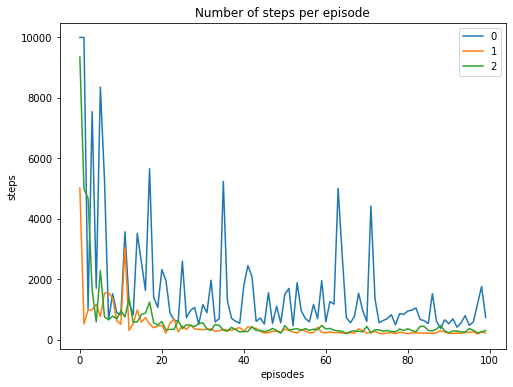

In [70]:
iht_size = [4096, 4096, 4096]
num_tilings = [2, 32, 8]
num_tiles = [16, 4, 8]
fig = plt.figure(figsize=[8, 6])

for i in range(3):
  steps = []
  agent = SarsaAgent(iht_size[i], num_tilings[i], num_tiles[i])
  env = gym.make('MountainCar-v0')
  env.reset()
  env._max_episode_steps = 10000
    
  state = env.reset()
  action = agent.agent_start(state)
  steps_per_episode = []

  for t in range(100):
      n_steps = 0
      done = False
      state = env.reset()
      
      while not done:
          state, reward, done, _ = env.step(action)
          n_steps += 1
          if done:
              agent.update_terminal_state(reward)
          else:
              action = agent.update(reward, state)

      steps_per_episode.append(n_steps)
      
  steps.append(np.array(steps_per_episode))

  steps_average = np.mean(np.array(steps), axis=0)
  plt.plot(steps_average, label = i)
  plt.xlabel('episodes')
  plt.ylabel('steps')
  plt.title('Number of steps per episode')
  plt.legend()